<a href="https://colab.research.google.com/github/onishiryo/CFDlecture/blob/main/2d-channel_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 0/5000 completed.
Step 500/5000 completed.
Step 1000/5000 completed.
Step 1500/5000 completed.
Step 2000/5000 completed.
Step 2500/5000 completed.
Step 3000/5000 completed.
Step 3500/5000 completed.
Step 4000/5000 completed.
Step 4500/5000 completed.


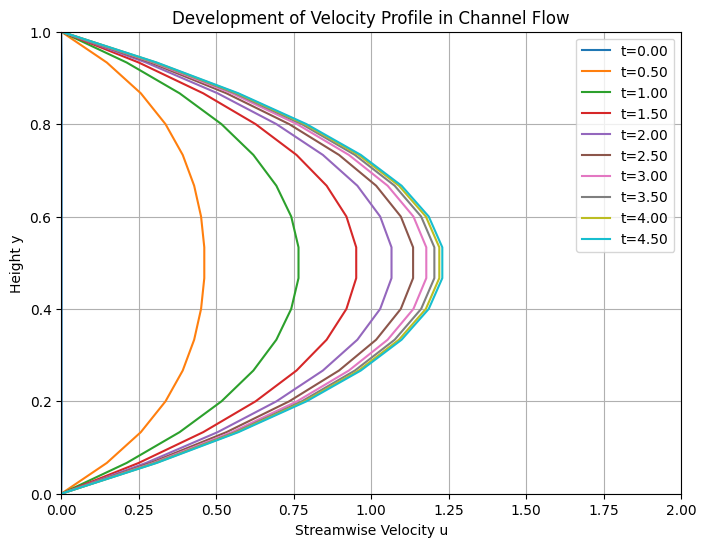

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#----------------------------
# Simulation Parameters
#----------------------------
Lx = 2.0       # Domain length in x-direction
Ly = 1.0       # Domain length in y-direction
Nx = 16        # Number of grid points in x
Ny = 16        # Number of grid points in y

Re = 10.0     # Reynolds number
U_bulk = 1.0   # Target bulk velocity

nu = U_bulk * Ly / Re    # Kinematic viscosity

dx = Lx / (Nx - 1)    # Grid spacing in x
dy = Ly / (Ny - 1)    # Grid spacing in y

dt = 0.001           # Time step size
n_steps = 5000       # Number of time steps
output_interval = 500  # Interval for plotting

pressure_gradient = 1.0   # Negative x-direction force

# SOR parameters
sor_omega = 1.7      # Over-relaxation factor
sor_tolerance = 1e-4 # Convergence tolerance
sor_max_iter = 5000  # Maximum number of iterations

#----------------------------
# Initialize Fields
#----------------------------
u = np.zeros((Nx, Ny))  # x-velocity
v = np.zeros((Nx, Ny))  # y-velocity
p = np.zeros((Nx, Ny))  # pressure field

# Add random perturbations to the initial velocity field
# np.random.seed(0)  # For reproducibility
# perturbation_strength = 0.01
# u += perturbation_strength * (np.random.rand(Nx, Ny) - 0.5)
# v += perturbation_strength * (np.random.rand(Nx, Ny) - 0.5)

#----------------------------
# Helper functions
#----------------------------

def sor_poisson(p, rhs, dx, dy, omega, tol, max_iter):
    pn = p.copy()
    dx2 = dx*dx
    dy2 = dy*dy
    for it in range(max_iter):
        max_error = 0.0
        for i in range(1, pn.shape[0]-1):
            for j in range(1, pn.shape[1]-1):
                p_old = pn[i,j]
                p_new = ((pn[i+1,j] + pn[i-1,j]) * dy2 +
                         (pn[i,j+1] + pn[i,j-1]) * dx2 -
                         rhs[i-1,j-1] * dx2 * dy2) / (2 * (dx2 + dy2))
                pn[i,j] = (1 - omega) * p_old + omega * p_new
                error = abs(pn[i,j] - p_old)
                if error > max_error:
                    max_error = error
        for j in range(pn.shape[1]):
            pn[0,j] = pn[1,j]
            pn[-1,j] = pn[-2,j]
        for i in range(pn.shape[0]):
            pn[i,0] = pn[i,1]
            pn[i,-1] = pn[i,-2]
        if max_error < tol:
            break
    return pn

#----------------------------
# Main Time Advancement Loop
#----------------------------

y_center = np.linspace(0, Ly, Ny)

plt.figure(figsize=(8,6))
plt.xlabel("Streamwise Velocity u")
plt.ylabel("Height y")
plt.title("Development of Velocity Profile in Channel Flow")
plt.grid()
plt.xlim(0, U_bulk * 2)
plt.ylim(0, Ly)

for n in range(n_steps):
    u_old = u.copy()
    v_old = v.copy()

    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            dudx = (u_old[i+1,j] - u_old[i-1,j]) / (2*dx)
            dudy = (u_old[i,j+1] - u_old[i,j-1]) / (2*dy)
            dvdx = (v_old[i+1,j] - v_old[i-1,j]) / (2*dx)
            dvdy = (v_old[i,j+1] - v_old[i,j-1]) / (2*dy)

            # lapu=dduddx+dduddy, lapv=ddvddx+ddvddy for diffusion term
            lapu = (u_old[i+1,j] - 2*u_old[i,j] + u_old[i-1,j]) / dx**2 + (u_old[i,j+1] - 2*u_old[i,j] + u_old[i,j-1]) / dy**2
            lapv = (v_old[i+1,j] - 2*v_old[i,j] + v_old[i-1,j]) / dx**2 + (v_old[i,j+1] - 2*v_old[i,j] + v_old[i,j-1]) / dy**2

            u[i,j] = u_old[i,j] + dt*(-(u_old[i,j]*dudx + v_old[i,j]*dudy) + nu*lapu + pressure_gradient)
            v[i,j] = v_old[i,j] + dt*(-(u_old[i,j]*dvdx + v_old[i,j]*dvdy) + nu*lapv)

    # Boundary condition: bottom wall (at y=0 & y=Ly, i.e., j=0 & Ny-1(=-1) )
    for i in range(Nx):
        u[i,0] = u[i,-1] = 0
        v[i,0] = v[i,-1] = 0

    # Boundary condition: periodic condition (inlet flow=outlet flow)
    for j in range(Ny):
        u[0,j] = u[-2,j] #inlet u=outlet u
        u[-1,j] = u[1,j] #outlet u=inlet u
        v[0,j] = v[-2,j]
        v[-1,j] = v[1,j]

    rhs = np.zeros((Nx-2, Ny-2))
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            dudx = (u[i+1,j] - u[i-1,j]) / (2*dx)
            dvdy = (v[i,j+1] - v[i,j-1]) / (2*dy)
            rhs[i-1,j-1] = (dudx + dvdy) / dt

    p = sor_poisson(p, rhs, dx, dy, sor_omega, sor_tolerance, sor_max_iter)

    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            dpdx = (p[i+1,j] - p[i-1,j]) / (2*dx)
            dpdy = (p[i,j+1] - p[i,j-1]) / (2*dy)
            u[i,j] -= dt * dpdx # i.e., u[i,j]=u[i,j]-dt*dpdx
            v[i,j] -= dt * dpdy

    # Boundary condition: bottom wall (at y=0 & y=Ly, i.e., j=0 & Ny-1(=-1) )
    for i in range(Nx):
        u[i,0] = u[i,-1] = 0
        v[i,0] = v[i,-1] = 0

    # Boundary condition: periodic condition (inlet flow=outlet flow)
    for j in range(Ny):
        u[0,j] = u[-2,j]
        u[-1,j] = u[1,j]
        v[0,j] = v[-2,j]
        v[-1,j] = v[1,j]

    if n % output_interval == 0:
        u_centerline = u[Nx//2,:]
        plt.plot(u_centerline, y_center, label=f"t={n*dt:.2f}")
        print(f"Step {n}/{n_steps} completed.")

plt.legend()
plt.show()